# Feature engineering

- toc: true
- branch: master
- badges: true
- comments: false
- author: Kirtikumar Pandya
- categories: [fastpages, Feature engineering, Machine learning]

In [53]:
# hide 
!pip install scipy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install statsmodels
!pip install -U scikit-learn

In [54]:
#hide 

# uncomment the line below to download titanic dataset.
# !mkdir data
# !wget https://raw.githubusercontent.com/pandya6988/my_first_fastpage/master/_notebooks/data/titanic.csv
# !cp titanic.csv data/.

In [55]:
# hide
import pandas as pd
from scipy import stats

## Definition

> Feature engineering is the process of transforming raw data into features that better represent the underlying signal to be fed to a machine learning model, resulting in improved model accuracy on unseen data. -- Derek Jedamski

## Motivation

Feature engineering is the most underrated topic in the machine learning field. Very few books actually concentrate on feature engineering techniques. The success of any machine learning model is depending on input features. 

<b> Garbage In, Garbage Out (GIGO)</b> : The quality of the output is highly dependent on the quality of the input. If you feed the bad features to the model, you will not get high quality output. Even though you have a lot of data and an incredible algorithm but with poorly defined features your model will perform poorly. 

Advantages of feature engineering:

- <b>Model flexibility</b>: With nice features, the choice of algorithm and hyperparameter tuning become less important. 
- <b>Simpler models</b>: with nice features, we don't need super complex algorithm. Even the simpler model can provide better result. These days, complex models are getting more attention, but simpler models are easy to understand, easy to debug, easy to optimize and often run faster than complex models. In the real world, if our model runs a couple of seconds faster, it is a huge win.
- <b>Better Result</b>: Garbage in, garbage out. 

## Loading data

We will use famous Titanic dataset. We will use `pandas` to read csv file. 

In [56]:
# collapse
titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


| Variable | Defination    | Key |
|--- |----------| ------|
| Survived |	Survival |	0 = No, 1 = Yes|
| Pclass |	Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd|
| Sex |	Sex	| |
| Age |	Age  in years | |
|SibSp |	# of siblings / spouses aboard the Titanic | |
|Parch | # of parents / children aboard the Titanic | |
|Ticket |  Ticket number | |
|Fare |	Passenger fare | |
|Cabin | Cabin number | |
|Embarked |	Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

In [57]:
#collapse
print(f"Titanic dataset has {titanic.shape[0]} entries and {titanic.shape[1]} features.")

Titanic dataset has 891 entries and 12 features.


## Data Exploration

### Continuous features

If we drop all categorical variables, it will look like below (Categirocal features are important but for now we will explore continuous features only):

In [58]:
# collapse
cat_feat = ['PassengerId', 'Name', 'Ticket', 'Sex', 'Cabin', 'Embarked']
titanic.drop(cat_feat, axis=1, inplace=True)
titanic.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [59]:
# collapse
titanic.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The table above reveals that:

- Target variable `Survived` is binary with mean 0.38 which means <b>38%</b> of the people survived. The dataset is <b>not highly</b> imbalanced. In the case of highly imbalanced dataset one should use oversampling or downsampling technique.
- `Pclass`, `SibSp` and `Parch` of descreate nature and have limited values.
- Titanic dataset has 819 entries but for `age` it shows only 714 entries. It means `Age` feature has <b> 177 missing values </b>. 

Now, let's explore correlation metrics. Keep in mind, negative correlation is equally important as positive correlation. The features used to predict the target variable should be less correlated with each other because it can confuse the model as it cannot parse out from which feature the signal is coming from. 

In [60]:
# collapse
print("Correlation matrix ⬇️")
titanic.corr()

Correlation matrix ⬇️


,Survived,Pclass,Age,SibSp,Parch,Fare
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


The target variable `Survived` has positive correlation with the feature `Fare`. Passengers who bought costly ticket had higher chance of survival.

`Fare` and `Pclass` have negative correlation. It means ticket class 1 is the costliest and 3 is the cheapest. 

In [61]:
# collapse_show
titanic.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


75 percentile of Pclass-1 > 75 percentile of Pclass-2 75 percentile of Pclass-3

In [62]:
# collapse
def describe_count_feature(feature):
    print(f"\n****** Result for {feature} ******")
    print(titanic.groupby('Survived')[feature].describe() )
    ttest(feature)
    
def ttest(feature):
    survived_feature = titanic[titanic.Survived == 1] [feature]
    not_survived_feature = titanic[titanic.Survived == 0] [feature]
    tstat, pval = stats.ttest_ind(survived_feature, not_survived_feature, equal_var=False)
    print(f"t-statistic: {tstat:.1f}, P-Vale: {pval:.3f}")

for feature in titanic.columns.drop('Survived'):
    describe_count_feature(feature)


****** Result for Pclass ******
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  2.531876  0.735805  1.0  2.0  3.0  3.0  3.0
1         342.0  1.950292  0.863321  1.0  1.0  2.0  3.0  3.0
t-statistic: -10.3, P-Vale: 0.000

****** Result for Age ******
          count       mean        std   min   25%   50%   75%   max
Survived                                                           
0         424.0  30.626179  14.172110  1.00  21.0  28.0  39.0  74.0
1         290.0  28.343690  14.950952  0.42  19.0  28.0  36.0  80.0
t-statistic: nan, P-Vale: nan

****** Result for SibSp ******
          count      mean       std  min  25%  50%  75%  max
Survived                                                    
0         549.0  0.553734  1.288399  0.0  0.0  0.0  1.0  8.0
1         342.0  0.473684  0.708688  0.0  0.0  0.0  1.0  4.0
t-statistic: -1.2, P-Vale: 0.233

****** Result for Parch ******
          count 

Interestingly, <b>result for Fare</b> shows that average ticket cost of the survived passengers is higher than the passengers who did not survive. Similar difference can be observed for mean, median and inter quantile ranges. 

Average age of the survived passenger ➡️ 30.63 years <br>
Average age of the non-survived passenger ➡️ 28.34 years <br> 
However, 50 percentile for survived and not survived is the same.

We saw above that `Age` has 177 missing value. It is important to understand if the age is missing for certain groups of people <u> OR</u> if it is missing in a systematic fashion. This will decide how we will handle the missing value.

In [63]:
# collapse
print(titanic.groupby(titanic.Age.isnull()).mean())
print('-----------')
print("⬆️ True indicates missing value.")

       Survived    Pclass        Age     SibSp     Parch       Fare
Age                                                                
False  0.406162  2.236695  29.699118  0.512605  0.431373  34.694514
True   0.293785  2.598870        NaN  0.564972  0.180791  22.158567
-----------
⬆️ True indicates missing value.


People without age reported are less likely to be survived, fewer parents/children, slightly higher class number and less fare.

### Visualize continuous features

Next, Let's plot the data to understand the distribution and the target variable.

In [64]:
# hide
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

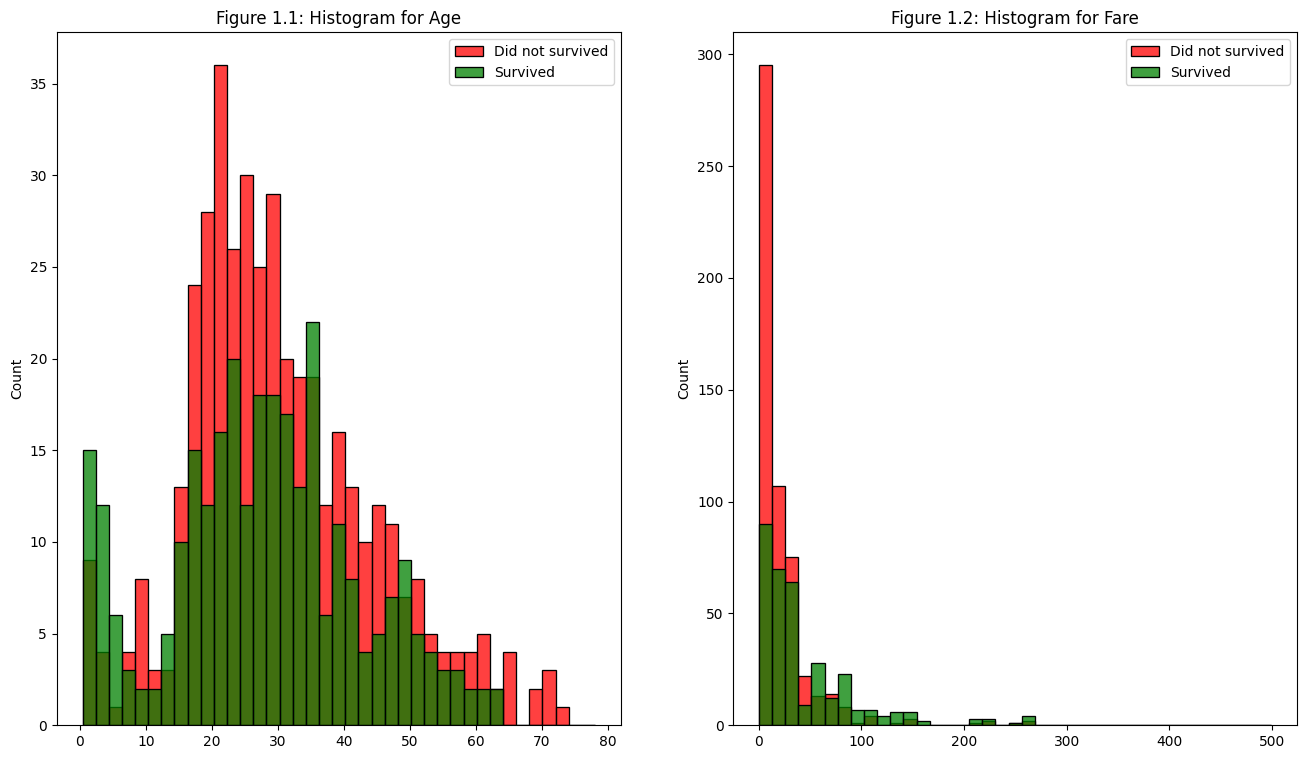

In [65]:
# collapse
fig, axs = plt.subplots(ncols=2, figsize=(16,9))
axs_no = 0

for feature in ['Age', 'Fare']:
    died = list(titanic[titanic.Survived == 0][feature].dropna())
    survived = list(titanic[titanic.Survived == 1][feature].dropna())
    xmin = min(min(died), min(survived))
    xmax = max( max(died), max(survived) )
    width = (xmax - xmin) / 40
    sns.histplot(died, color='r', kde=False, bins=np.arange(xmin, xmax, width), ax=axs[axs_no])
    sns.histplot(survived, color='g', kde=False, bins=np.arange(xmin, xmax, width), ax=axs[axs_no])
    axs[axs_no].set_title(f"Figure 1.{axs_no+1}: Histogram for {feature}")
    axs[axs_no].legend(['Did not survived', 'Survived'])
    axs_no += 1

In the section above, we observed almost no difference in the age for the group who survived and who did not. The histogram shown in <b>figure 1.1</b> confirms that.

<p> Previously, we observed that on average, passengers who survived paid a very high price for the ticket as compared to passengers who did not survive. 

- Mean `Fare` for people who survived ➡️ ~48
- Mean `Fare` for people who did not survive ➡️ ~22 

<u>The overlaid histogram (Figure 1.2) highlights the caution you have to take by looking only at averages instead of the full distribution.</u> Except the first bin of the histogram, the likelihood of surviving versus not surviving is very similar. For example, in the case of the second bin, we can observe $\approx$ 105 for people who did not survive and $\approx$ 70 for people who survived. 

The histogram for feature `Fare` (<b>Figure 1.2</b>) shows <b>minor</b> differences between the two distributions, unlike what we observed by comparing mean values. The big difference between mean values is influenced by some outliers.

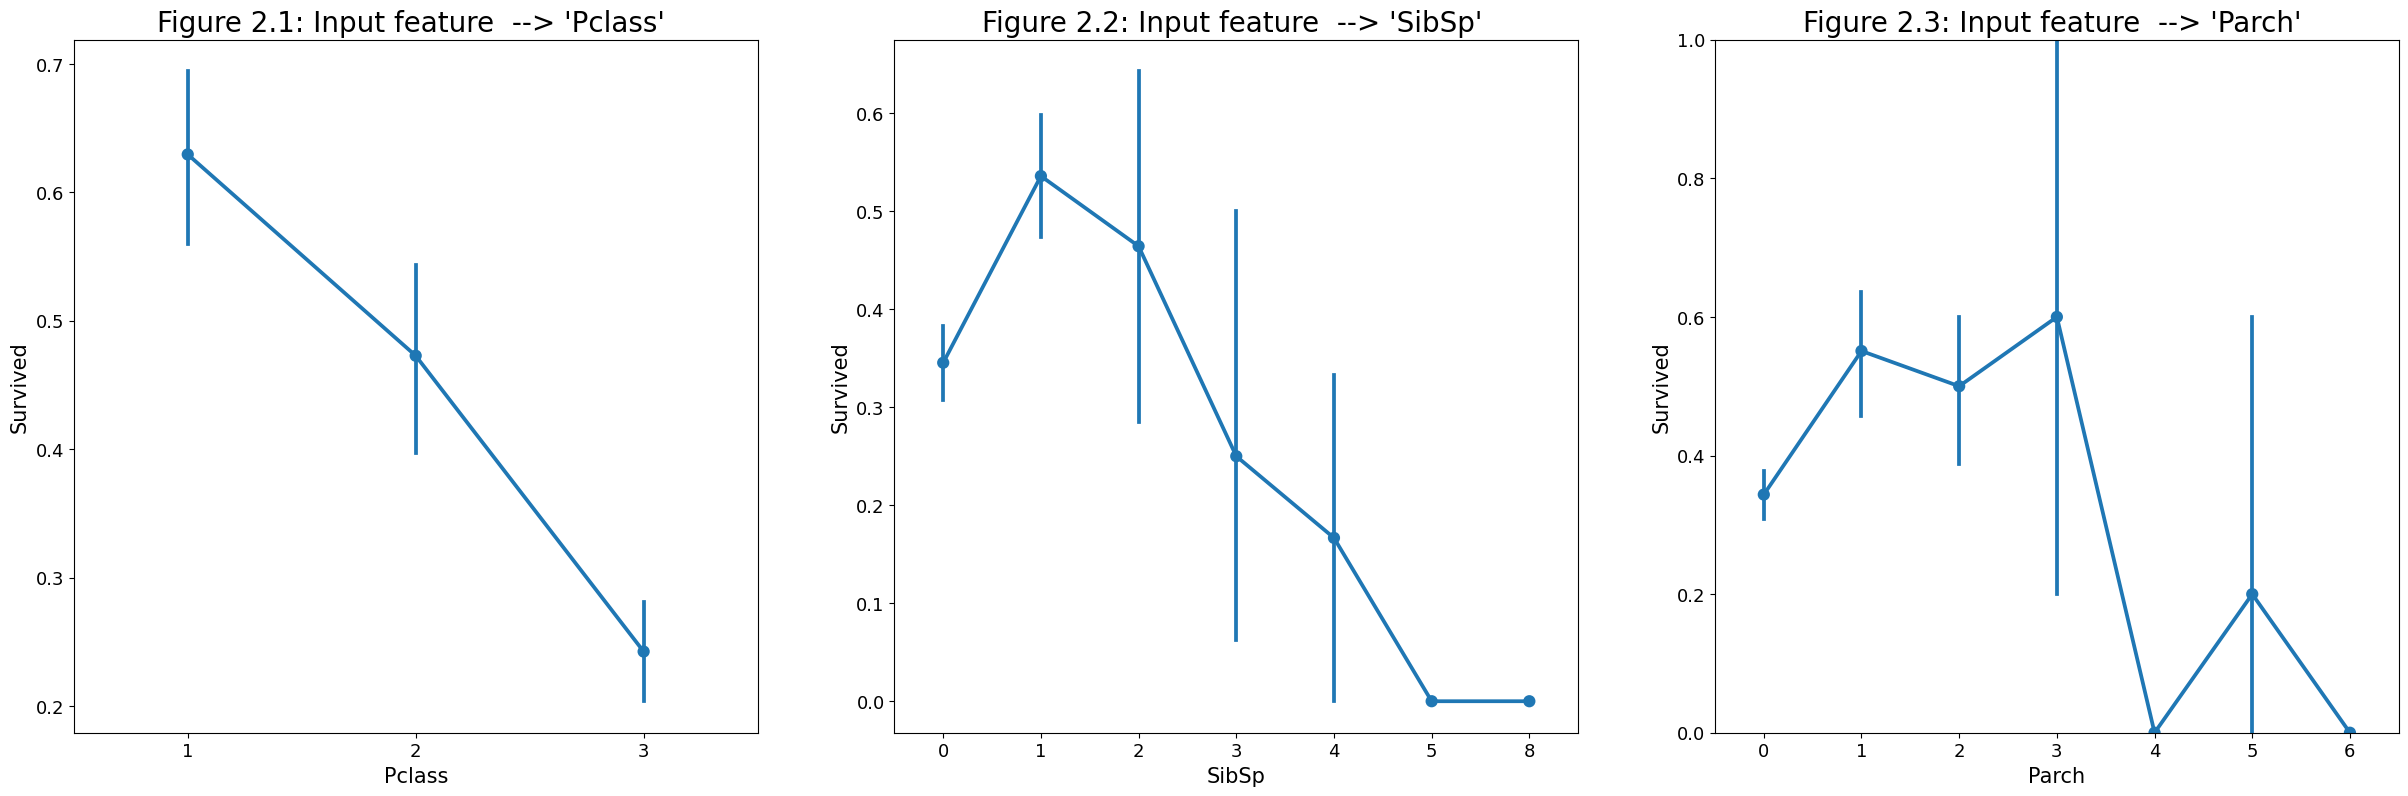

In [66]:
# collapse

fig, axs = plt.subplots(ncols=3, figsize=(30,9))
axs_no = 0
ordinal_features = ['Pclass', 'SibSp', 'Parch']

for feature in ordinal_features:
    axs[axs_no].tick_params(axis='x', labelsize=13)
    axs[axs_no].tick_params(axis='y', labelsize=13)
    axs[axs_no].set_xlabel(f"{feature}", fontsize=15)
    axs[axs_no].set_ylabel("Survived", fontsize=15)
    sns.pointplot(x=feature, y='Survived', data=titanic, ax=axs[axs_no])
    axs[axs_no].set_title(f"Figure 2.{axs_no+1}: Input feature  --> '{feature}' ", fontsize=20)
    axs_no += 1
    plt.ylim(0,1)

Figure 2.x shows the percentage of people survived at each level of the input feature. The vertical lines represent the confidence level. Input with limited examples will result in a bigger line and represent less confidence. 

Figure 2.1 depicts that first class passengers (`Pclass`=1) are the most likely to survive (around 64% probability) and third class passengers are the least likely to survive. Here, we can see a clear trend. 

<i>Likelihood of first class passenger survive</i> <b>></b> <i>Likelihood of second class passenger survive</i> <b>></b> <i>Likelihood of third class passenger survive</i>

Figure 2.2 and figure 2.3 show that as the number of family members increases, the likelihood of surviving is reduced. Both plots show almost similar trends, therefore we can combine these two features and reduce redundancy. We have combined the features `SibSp` and `Parch` and added a new feature called `family_members`.

family members = (number of siblings / spouses aboard the Titanic) + (number of parents / children aboard the Titanic)

$family\_member = SibSp + Parch$

We will decide later whether we should use the reduced feature (`family_members`) <u>OR</u> use two separate features.

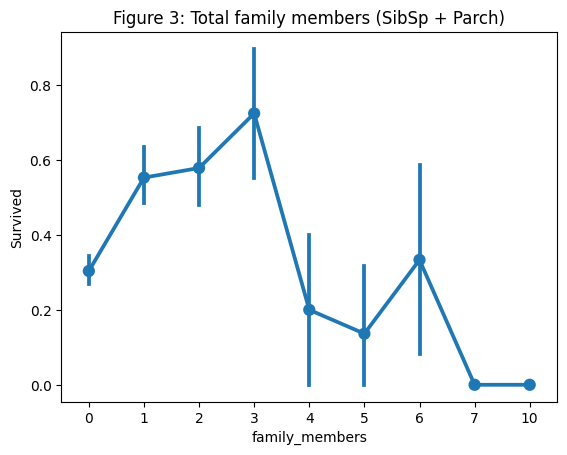

In [67]:
# collapse

titanic['family_members'] = titanic['SibSp'] + titanic['Parch']
sns.pointplot(x='family_members', y='Survived', data=titanic)
plt.title(f"Figure 3: Total family members (SibSp + Parch)")
plt.show()

We can observe from figure 3 that the probability of surviving increases till three `family_members` and after that we are observing sudden drop in the values. 

### Categirocal features

Now, let's explore the categorical features.

In [68]:
# collapse

titanic = pd.read_csv('data/titanic.csv')
continuous_features = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age', 'PassengerId']
titanic.drop(columns=continuous_features, axis=1, inplace=True)
categorical_features = list(titanic.columns)
titanic.head()

,Survived,Name,Sex,Ticket,Cabin,Embarked
0,0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,1,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,0,"Allen, Mr. William Henry",male,373450,NaN,S


In [69]:
# collapse

print("⬇️ Total NaN values for each categorical feature.")
print(titanic.isnull().sum())

⬇️ Total NaN values for each categorical feature.
Survived      0
Name          0
Sex           0
Ticket        0
Cabin       687
Embarked      2
dtype: int64


Now, we will see the number of unique value for each categorical feature. 

In [70]:
# collapse
number_of_unique_values = dict()
for feature in titanic.drop('Survived', axis=1).columns:
    number_of_unique_values[feature] = titanic[feature].nunique()

data = np.array([list(number_of_unique_values.keys()), list(number_of_unique_values.values())])
pd.DataFrame(data=data.T, columns=['features', '# of unique values'])

,features,# of unique values
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3


For the `Cabin` feature, we have 687 NaN values (out of 891 entries). Out of 204 available values, 147 are unique. At first glance, this feature does not look useful for the prediction. Let's further investigate this feature for better understanding.

In [71]:
# collapse
print(titanic.groupby(titanic.Cabin.isnull()).mean())
print("⬆️ True indicates the missing value.")

       Survived
Cabin          
False  0.666667
True   0.299854
⬆️ True indicates the missing value.


The code cell above reveals that only $\approx$ 30% passengers without Cabin information could servive. What could have happened that actually no cabin was allocated to few passengers and they were sleeping at one place. Here, reason is not important. We can replace this feature with `Cabin_info` feature which indicates that whether the `Cabin` information is available or not. `Cabin_info` can be seen as a feature with binary values.

In [72]:
titanic['Cabin_info'] = np.where(titanic.Cabin.isnull(), 0, 1)

The titanic dataset has 681 unique ticket values out of 891 values with 0 NaN value. From this feature we will not get any useful signal and therefore we will drop the `Ticket` column. Readers can explore this feature further (small exercise if you are interested).

Next, let's investigate the feature `Name`. Logically, name cannot have any influence whether he survived or not. However, if the passenger has a special title (like Master, prof. etc.), it can give him special privileges. It is worth exploring.

In [73]:
# collapse
print("5 most common titles ⬇️")
titanic['Title_raw'] = titanic.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())

titanic.pivot_table('Survived', index=['Title_raw', 'Sex'], aggfunc=['count', 'mean']).sort_values([( 'count', 'Survived')], ascending=False) [:5]

5 most common titles ⬇️


,,count,mean
,,Survived,Survived
Title_raw,Sex,,
Mr,male,517,0.156673
Miss,female,182,0.697802
Mrs,female,125,0.792000
Master,male,40,0.575000
Rev,male,6,0.000000


The pivot table above reveals that a name with the title "Mrs" has $\approx$ 80% chance of survival, name with the title "Miss" has $\approx$ 70% of chance of survival. We will keep the 4 most common titles and group the others (please refer to feature `Title` in the dataframe below).

In [74]:
# collapse

titanic['Title'] = titanic.Title_raw.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'other')
titanic.drop(['Name', 'Ticket', 'Cabin', 'Title_raw'],axis=1).sample(frac=1).reset_index(drop=True). head(8)

,Survived,Sex,Embarked,Cabin_info,Title
0,1,male,C,1,Mr
1,1,female,S,0,Mrs
2,0,male,S,0,Mr
3,0,male,S,0,Mr
4,0,male,S,1,Mr
5,1,female,S,1,Miss
6,1,female,S,0,Miss
7,0,male,S,0,Mr


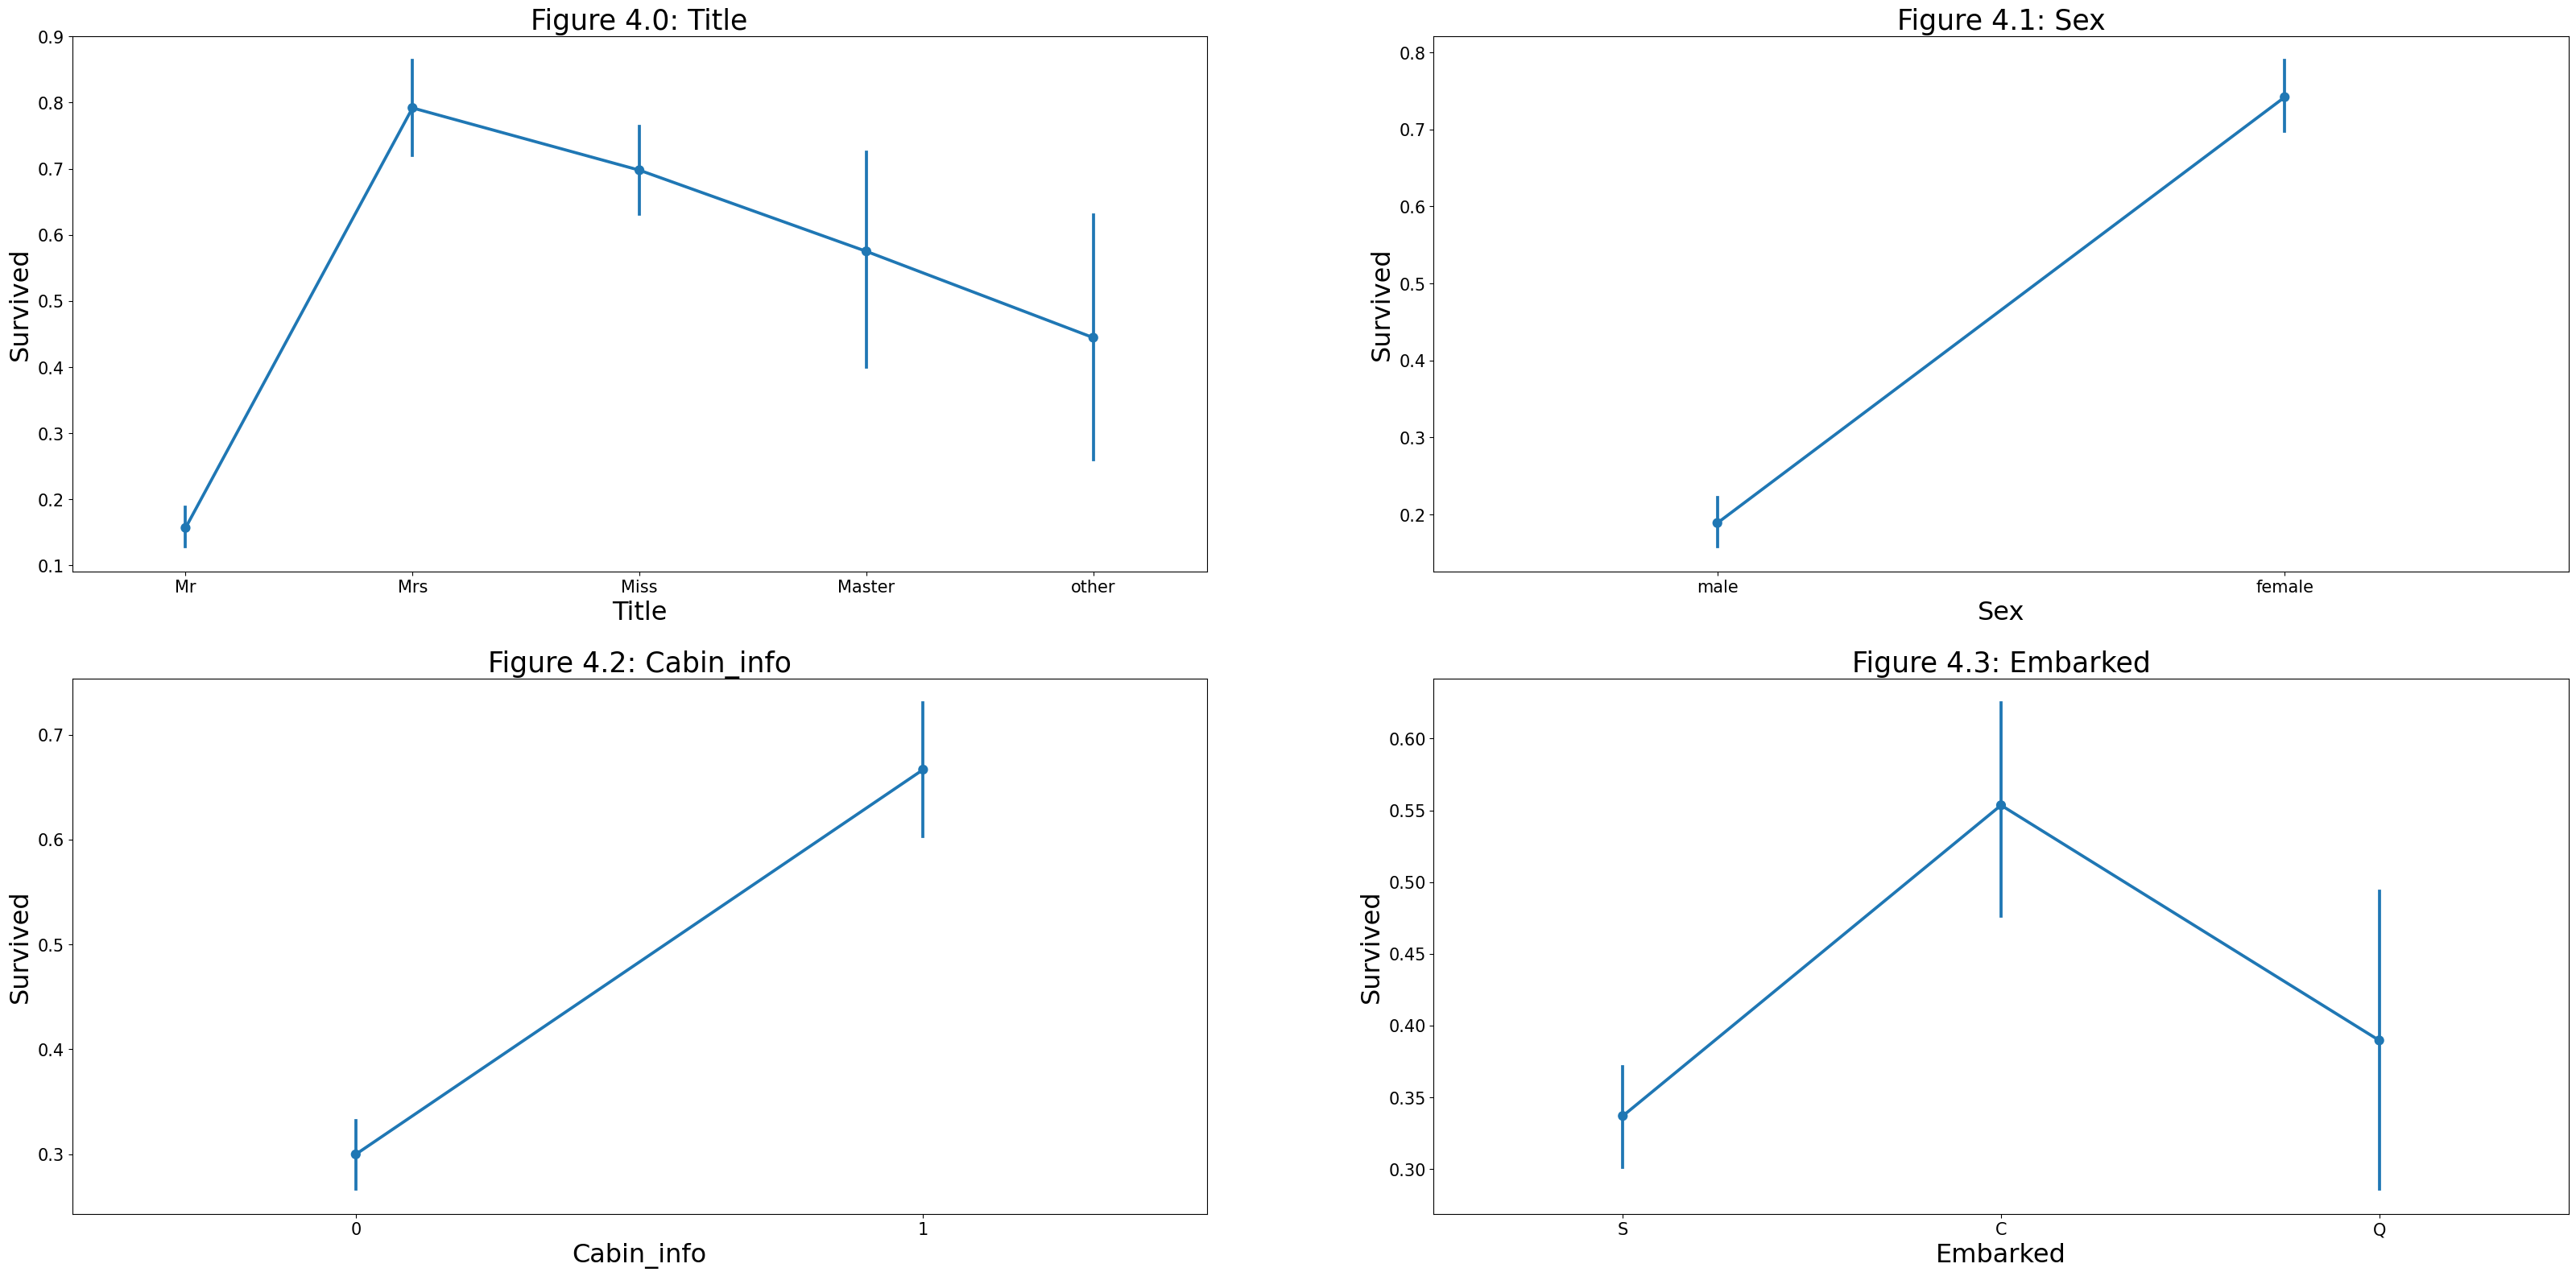

In [75]:
# collapse

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(40,19))
axs_no = 0
n_row = 0
n_col = 0
for feature in ['Title', 'Sex', 'Cabin_info', 'Embarked']:
    axs[n_row][n_col].tick_params(axis='x', labelsize=15)
    axs[n_row][n_col].tick_params(axis='y', labelsize=15)
    sns.pointplot(x=feature, y='Survived', data=titanic, ax=axs[n_row][n_col])
    axs[n_row][n_col].set_title(f"Figure 4.{axs_no}: {feature}", fontsize=25)
    axs[n_row][n_col].set_xlabel(f'{feature}', fontsize=23)
    axs[n_row][n_col].set_ylabel('Survived', fontsize=23)
    axs_no += 1
    n_row = 1 if axs_no > 1 else 0
    n_col = 1 if n_col == 0 else 0
    

The likelihood of survival cannot be dependent on the embarkation port. Passengers from one port can be richer than other ports and, therefore, they can afford a ticket with cabin (Pivot table below confirms our hypothesis). However, we are considering `Cabin_info` separately, and therefore we can ignore the `Embarked` feature. We will drop the feature shown in figure 4.3.

In [76]:
# collapse

titanic.pivot_table('Survived', index=['Cabin_info'], columns=['Embarked'], aggfunc='count')

Embarked,C,Q,S
Cabin_info,,,
0,99,73,515
1,69,4,129


### Summary

- <b>Name</b> &nbsp; : Name on its own was not very valuable. Somebody's name probably didn't determine whether they are likely to survive. However, name title can be the proxy for a status and is likely related to whether they survive or not. Therefore, we have decided `Title` is more useful feature than `Name`.
- <b>Pclass</b> &nbsp; : <i>Likelihood of first class passenger survive</i> <b>></b> <i>Likelihood of second class passenger survive</i> <b>></b> <i>Likelihood of third class passenger survive</i> (<b>as shown in figure 2.1</b>). 
- <b>Sex</b> &nbsp;: Female has $\approx$ 74% chance of survival and male has only $\approx$ 19% chance of survival (<b>as shown in figure 4.1</b>).
- <b>Age</b> &nbsp;: As shown in figure 1.1 `Age` distribution for both cases (survived and not survived) are the same. 
- <b>SibSp + Parch </b>&nbsp;: We realized that these two features tells the same story and therefore we have decided to combine those into one feature.
- <b>Ticket</b> &nbsp;: We validated that ticket number is random and does not provide any important information. 
- <b>Fare</b> &nbsp;: It is more correlated to `Pclass`. In the future we can investigate if we can use only one of these features to achieve the same or better accuracy. 
- <b>Cabin</b> &nbsp;: Cabin is missing for more than 75% of passengers. We could have assumed that it was missing randomly and dropped the entire feature. However, we uncovered the fact that there was a strong correlation between the cabin being missing and the survival rate. Therefore, we converted this categorical feature to a binary indicator that seems to be very powerful predictor of whether a passenger survived. 
- <b>Embarked</b> &nbsp;: We have concluded that it is not a causal factor. It is likely correlated with some other feature and that other feature is probably the driving factor here. 


## Creating and cleaning features

In [77]:
# hide

titanic = pd.read_csv('data/titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Handling missing values in the data

In [78]:
# hide_input
Null_values = pd.DataFrame( titanic.isnull().sum(), columns=["Null values"] )
Null_values

,Null values
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


The table above shows the missing values for each input feature. `Age` has 177 missing values, Cabin has 687 missing values, and `Embarked` has only two missing values. It is very important to investigate data to come up with good imputation strategy. 

<b><u>Age</u></b>

In the <i>Feature exploration</i> section, we saw that the age distribution for passengers who survived and who did not is the same. Therefore, we will assume that it is missing randomly and <b>replace it with mean value</b>. This is the most naive but useful method. This way, it satisfies the model by making sure we have value in there, but by replacing it with average, it is not biasing the model towards one outcome or another.

<b><u>Embarked</u></b>

`Embarked` has only two unknown values. We can replace the missing value with the most frequent value.

<b><u>Cabin</u></b>

In the previous section, we saw that only $\approx$ 30% passengers without cabin information could survive. What could have happened that actually no cabin was allocated to few passengers and they were sleeping at one place. Here, reason is not important. We can replace this feature with `Cabin_info` feature which indicates that whether the `Cabin` information is available or not. `Cabin_info` can be seen as a feature with binary values.

In [79]:
titanic['Age_clean'] = titanic['Age'].fillna(titanic.Age.mean())
titanic['Embarked_clean'] = titanic['Embarked'].fillna('S')
titanic['Cabin_info'] = np.where(titanic.Cabin.isnull(), 0, 1)

In [80]:
# hide
# Here we can see that three new features do not have NaN values
Null_values = pd.DataFrame( titanic.isnull().sum(), columns=["Null values"] )
Null_values

,Null values
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [81]:
# hide 
titanic.to_csv('data/titanic_no_missing_.csv', index=False)

### Removing outliers

In order to detact outliers we have to consider it's distibution. we can detect outliers for `Fare` for each `Pclass` and clip the value accordingly. For now we will remove outliers in 1-dimensional space and consider each feature as whole. 

maximum value for features `Fare` and `age` look little extreme (in the table below compare max value with 75%) but rest seems okay.

In [82]:
# collapse

titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Cabin_info
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.699118,0.228956
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,13.002015,0.420397
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,22.000000,0.000000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,29.699118,0.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,35.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,80.000000,1.000000


1 class passengers got titcket for free: 5
2 class passengers got titcket for free: 6
3 class passengers got titcket for free: 4


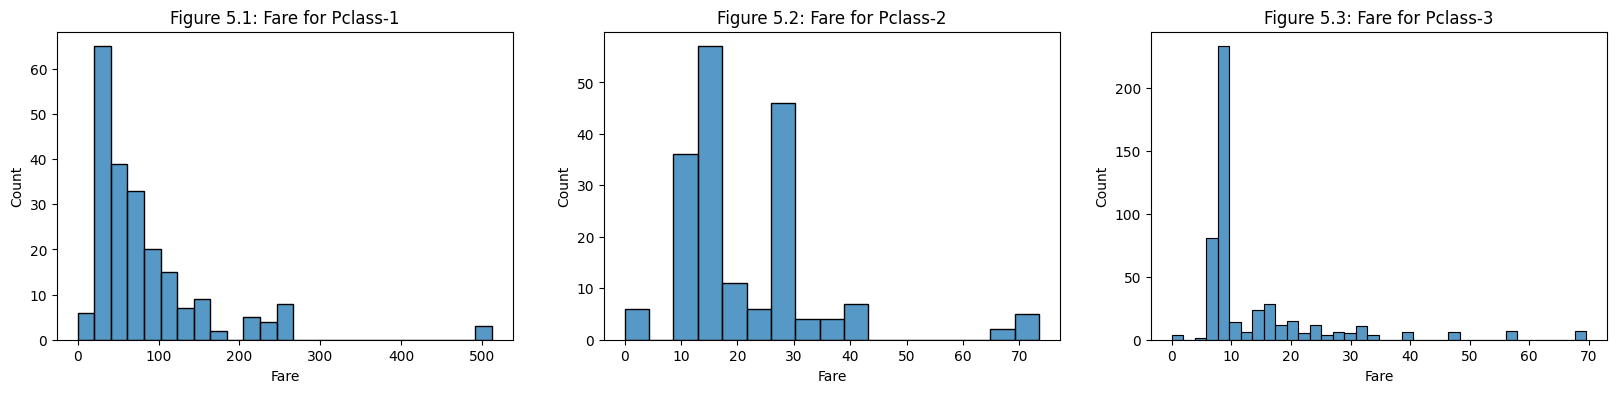

In [83]:
# hide

fig, axs = plt.subplots(ncols=3, figsize=(20,4))
axs_no = 0

for pclass in range(1,4):
    data = titanic.Fare[titanic.Pclass==pclass]
    sns.histplot(data, ax=axs[axs_no] )
    axs[axs_no].set_title(f"Figure 5.{axs_no+1}: Fare for Pclass-{pclass}")
    axs_no += 1
    print(f"{pclass} class passengers got titcket for free: {sum(data==0)}")

In [84]:
# collapse

def detect_outliers(feature):
    outliers = []
    data = titanic[feature]
    mean = np.mean(data)
    std = np.std(data)
    
    for entry in data:
        zscore = (entry - mean) / std 
        if zscore > 3: outliers.append(zscore)
        
    print(f"\nOutliers for {feature}")
    print(f"  -- 95p: {data.quantile(0.95)} / Exceed values: {sum(data > data.quantile(0.95)) }")
    print(f"  -- 3sd: {mean + (3*std)} / Exceed values: {len(outliers) }")
    print(f"  -- 99p: {data.quantile(0.99)} / Exceed values: {sum(data > data.quantile(0.99)) }")
    
for feature in ['Fare', 'Age_clean']:
    detect_outliers(feature)


Outliers for Fare
  -- 95p: 112.07915 / Exceed values: 45
  -- 3sd: 181.20081130289697 / Exceed values: 20
  -- 99p: 249.00622000000035 / Exceed values: 9

Outliers for Age_clean
  -- 95p: 54.0 / Exceed values: 42
  -- 3sd: 68.68326826542591 / Exceed values: 7
  -- 99p: 65.0 / Exceed values: 8


9 values exceed the 0.99 percentile for feature `Fare` and 8 values for feature `Age`. 

In [85]:
titanic['Fare_clean']= titanic['Fare'].clip(upper=titanic['Fare'].quantile(0.99))
titanic['Age_clean'].clip(upper=titanic['Age_clean'].quantile(0.99), inplace=True)

In [86]:
# hide
# Now you can compare the results before and after clipping the value. 
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Age_clean,Cabin_info,Fare_clean
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,29.640195,0.228956,31.224767
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,12.820616,0.420397,42.524125
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.420000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,22.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,29.699118,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,35.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,65.000000,1.000000,249.006220


In [87]:
# hide
titanic.to_csv('data/titanic_capped_.csv', index=False)

In [88]:
# hide
from statsmodels.graphics.gofplots import qqplot

### Transforming skewed features

Next, we will see if some transformation is necessary for each <u>continuous</u> feature.

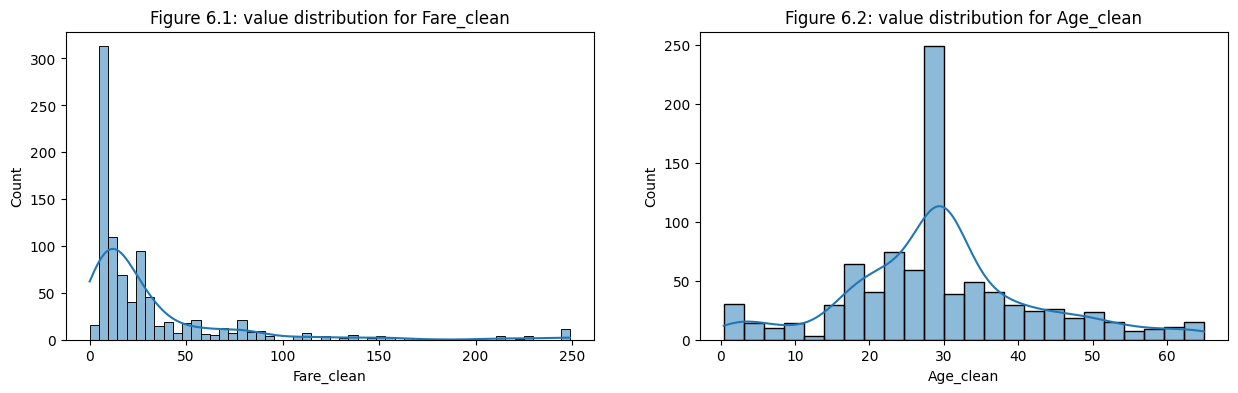

In [89]:
# collapse

fig, axs = plt.subplots(ncols=2, figsize=(15,4))
axs_no = 0

for feature in ['Fare_clean', 'Age_clean']:
    data = titanic[feature]
    sns.histplot(data, ax=axs[axs_no], kde=True )
    axs[axs_no].set_title(f"Figure 6.{axs_no+1}: value distribution for {feature}")
    axs_no += 1    

Figure 6.2 represents the value distribution for feature `Age_clean`. The distribution looks good. We have replaced missing value with the mean which results into long bar at the middle. 

Figure 6.1 represents the value distribution for feature `Fare_clean` where we have clipped the upper value to 0.99 quantile. Clipping the values helped as before it was till 500 but still the tail of the distribution is still long. Let's try different transformations to reduce the tail and make the distribution more compact. 

Now, we will investigate which Box-Cox power transformation can be use. Below you can see different trasnformation plots. (you can see plot for different transformation under <b>show output</b>) button.

<u>Note</u>: Ideally, blue dots should be align with red line. 

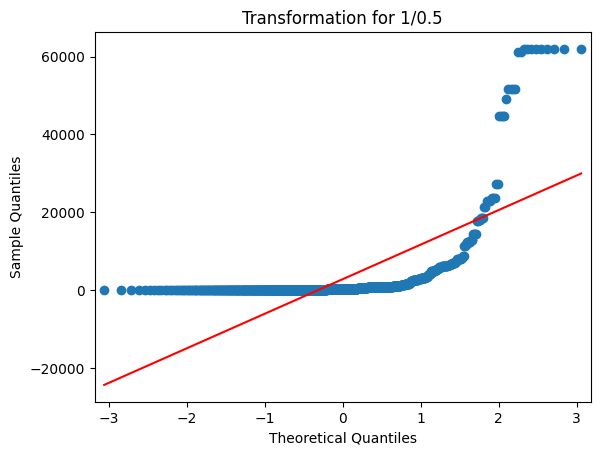

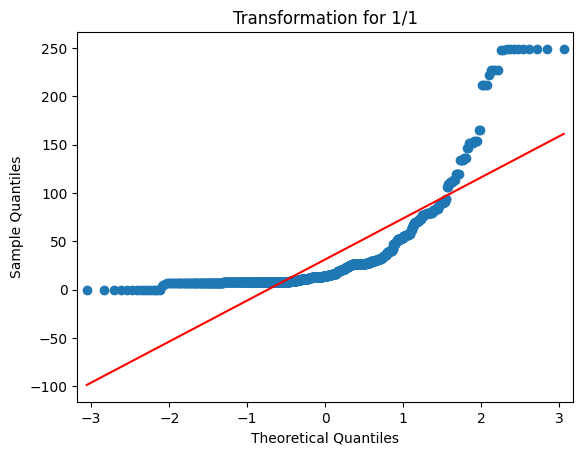

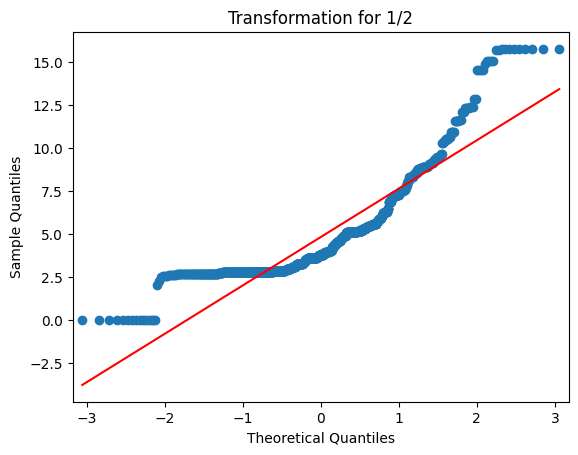

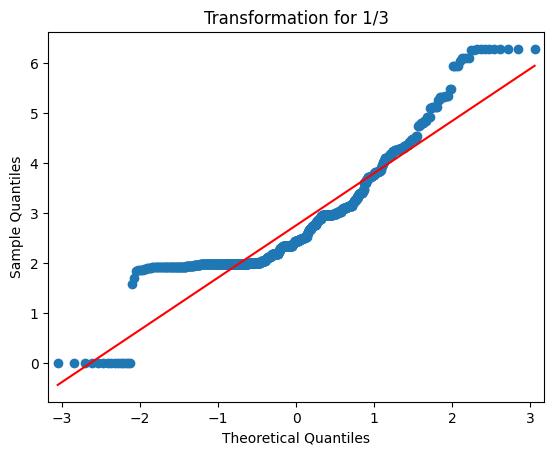

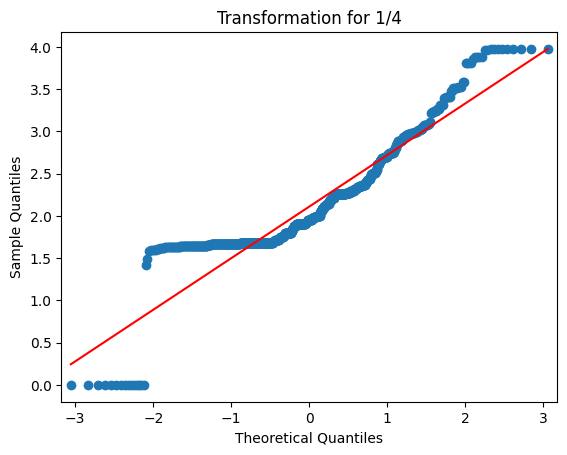

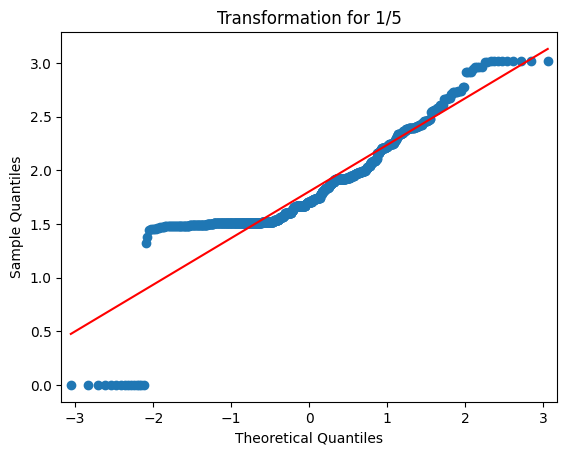

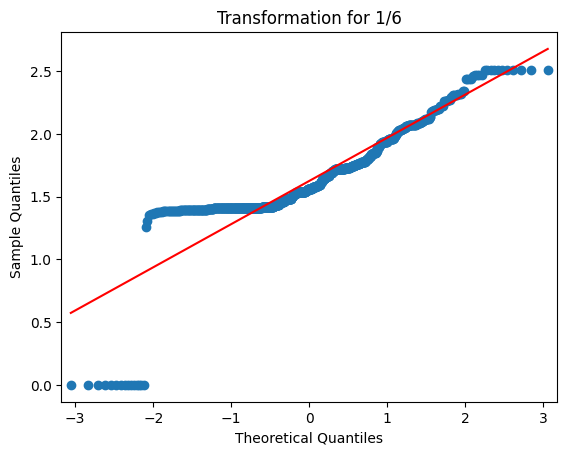

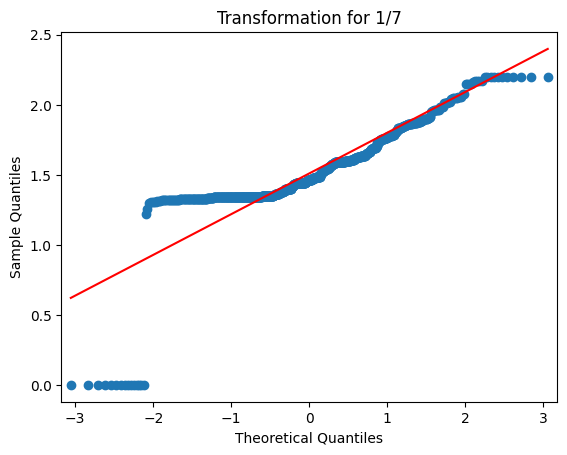

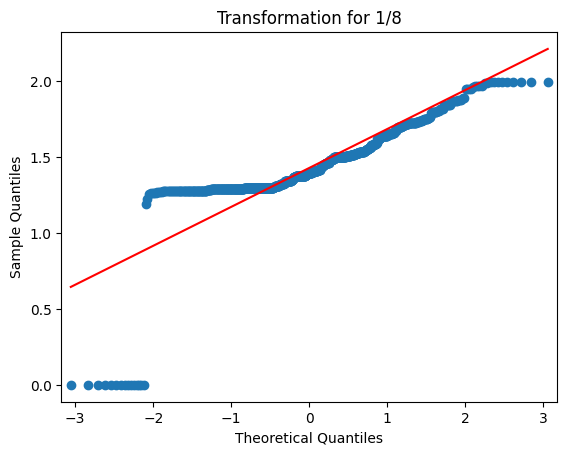

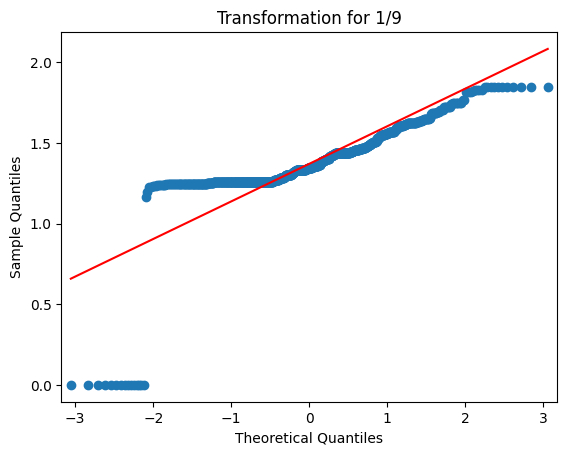

In [90]:
# collapse_output

for i in [0.5, 1, 2,3,4,5,6,7,8,9]:
    data_t = titanic.Fare_clean ** (1/i)
    qqplot(data_t, line='s')
    plt.title(f"Transformation for 1/{i}")

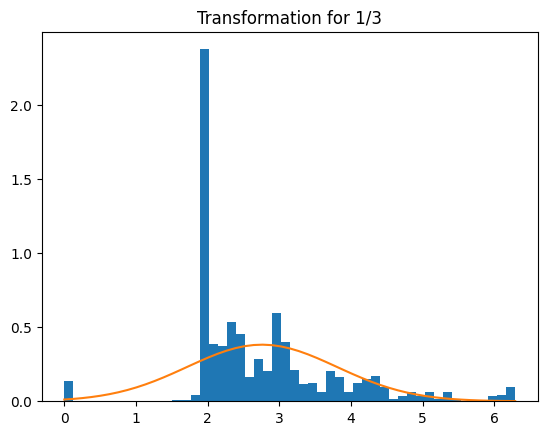

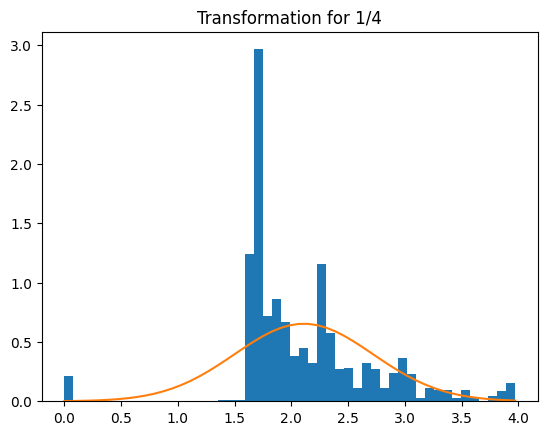

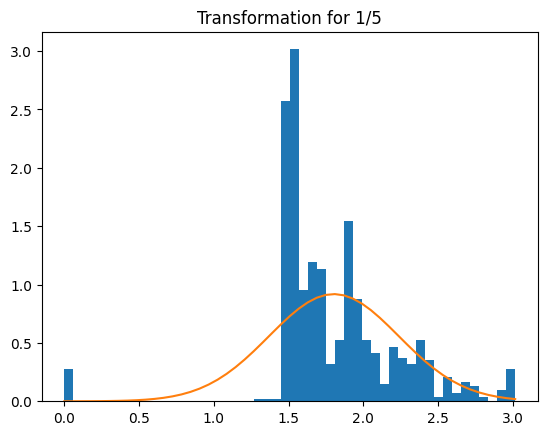

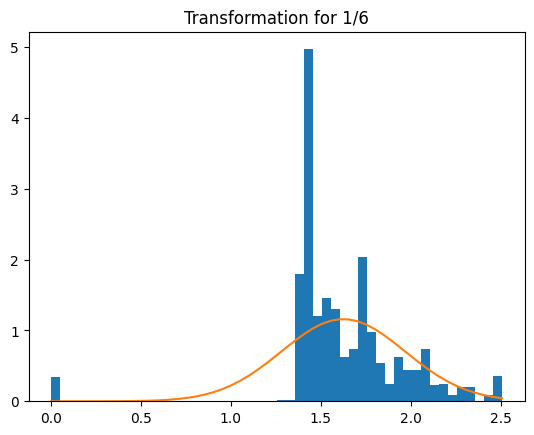

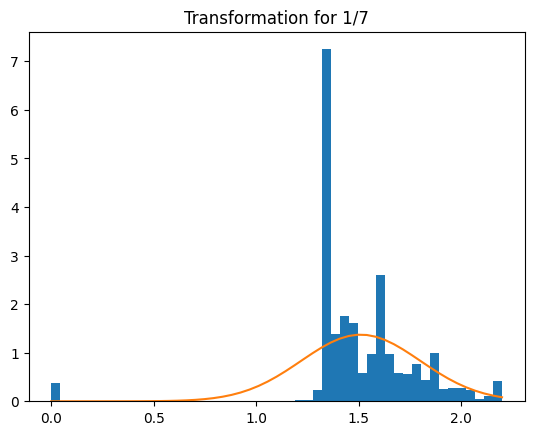

In [91]:
# collapse_output

for i in [3,4,5,6,7]:
    if i != 0:
        data_t = titanic.Fare_clean ** (1/i)
    else:
        data_t = np.log(titanic.Fare_clean)
    n, bins, patches = plt.hist(data_t, 50, density=True)
    mu = np.mean(data_t)
    sigma = np.std(data_t)
    plt.plot(bins, stats.norm.pdf(bins, mu, sigma))
    plt.title(f"Transformation for 1/{i}")
    plt.show()

All plots above looks better than initial value distribution. We will perform <b>1/5 transformation</b>. 

In [92]:
titanic['Fare_clean_tr'] = titanic['Fare_clean'].apply(lambda x: x ** (1/5))
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Cabin_info,Fare_clean,Fare_clean_tr
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,0,7.2500,1.486167
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,1,71.2833,2.347457
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,0,7.9250,1.512864
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,1,53.1000,2.213191
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,0,8.0500,1.517606


In [93]:
# hide
titanic.to_csv('data/titanic_transformed_.csv', index=False) 

In <b>data exploration</b> we have discussed the importance of the passenger's title, total family members (SibSp+Parch), and cabin indicator.

In [94]:
titanic['Title'] = titanic['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
titanic['Ttile_clean'] = titanic.Title.apply(lambda x: x if x in ['Mr', 'Miss', 'Mrs', 'Master'] else 'other')
titanic['family_members'] = titanic['SibSp'] + titanic['Parch']
titanic['Cabin_info'] = np.where(titanic.Cabin.isnull(), 0, 1)
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_clean,Embarked_clean,Cabin_info,Fare_clean,Fare_clean_tr,Title,Ttile_clean,family_members
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,S,0,7.2500,1.486167,Mr,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,C,1,71.2833,2.347457,Mrs,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,S,0,7.9250,1.512864,Miss,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,S,1,53.1000,2.213191,Mrs,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,S,0,8.0500,1.517606,Mr,Mr,0


### convert categorical feature to numeric 

It is not necessary to convert categorical features to numeric features. It depends on which algorithm you choose to predict the target feature. For example, if you want to use neural networks, you have to convert those to numeric. On the other hand, decision tree or random forest can use the categorical features to predict the target.

> Note: We will use random forest model to predict target feature. However, let's see how you can convert categorical feature to numeric. 

In [95]:
# hide

print(titanic.columns)
categorical_features = ['Sex', 'Embarked_clean', 'Ttile_clean']

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_clean',
       'Embarked_clean', 'Cabin_info', 'Fare_clean', 'Fare_clean_tr', 'Title',
       'Ttile_clean', 'family_members'],
      dtype='object')


In [96]:
# collapse
from sklearn.preprocessing import LabelEncoder

for feature in categorical_features:
    label_encoder = LabelEncoder()
    titanic[f"{feature}_numeric"] = label_encoder.fit_transform(titanic[feature].astype(str))
    print(f"\n{feature}:")
    for i, cl in enumerate(list(label_encoder.classes_)):
        print(f"    number {i}  -->  {cl}")
    print('----------------------')
    
titanic[['Sex', 'Embarked_clean', 'Ttile_clean', 'Sex_numeric', 'Embarked_clean_numeric', 'Ttile_clean_numeric']].head()


Sex:
    number 0  -->  female
    number 1  -->  male
----------------------

Embarked_clean:
    number 0  -->  C
    number 1  -->  Q
    number 2  -->  S
----------------------

Ttile_clean:
    number 0  -->  Master
    number 1  -->  Miss
    number 2  -->  Mr
    number 3  -->  Mrs
    number 4  -->  other
----------------------


,Sex,Embarked_clean,Ttile_clean,Sex_numeric,Embarked_clean_numeric,Ttile_clean_numeric
0,male,S,Mr,1,2,2
1,female,C,Mrs,0,0,3
2,female,S,Miss,0,2,1
3,female,S,Mrs,0,2,3
4,male,S,Mr,1,2,2


In [97]:
# hide

titanic.Age = titanic.Age.fillna(-1000)
label_encoder = LabelEncoder()
titanic["Cabin_numeric"] = label_encoder.fit_transform(titanic['Cabin'].astype(str))
titanic["Embarked_numeric"] = label_encoder.fit_transform(titanic['Embarked'].astype(str))

## Prepare features for modeling

### train-test split 

Next, we will do train-test split using sklearn library. We will split the dataset into two sets. The model will trained using the 60% of the data, validate the model using 20% of the data and test using another 20% of the data. We do this because our model should perform well on unseen data. I am not going into detail. There are many awesome blogs on this topic. 

> Note: Our dataset is not balanced and therefore we have to consider this while splitting the data. We have set `Survived` feature to stratify.

In [98]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(titanic.drop('Survived', axis=1), titanic['Survived'], stratify=titanic.Survived, test_size=0.4, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, shuffle=True)

In [99]:
# collapse

print(f"X_train\t: {round(len(X_train)/len(titanic),2)*100}% of original dataset.")
print(f"X_val \t: {round(len(X_val)/len(titanic),2)*100}% of original dataset.")
print(f"X_test \t: {round(len(X_test)/len(titanic),2)*100}% of original dataset.")

X_train	: 60.0% of original dataset.
X_val 	: 20.0% of original dataset.
X_test 	: 20.0% of original dataset.


### standardieze features (z-score)

The titanic dataset has features with different value range. For example, compare the value difference between features `Age` and `Fare` (refer the table below). Deep learning algorithm suffer from this kind features, specially logistic regression. 

In [100]:
# collapse

titanic[['Age_clean', 'Fare_clean_tr', 'SibSp', 'Parch']].describe()

,Age_clean,Fare_clean_tr,SibSp,Parch
count,891.000000,891.000000,891.000000,891.000000
mean,29.640195,1.802562,0.523008,0.381594
std,12.820616,0.434645,1.102743,0.806057
min,0.420000,0.000000,0.000000,0.000000
25%,22.000000,1.512306,0.000000,0.000000
50%,29.699118,1.706078,0.000000,0.000000
75%,35.000000,1.987341,1.000000,0.000000
max,65.000000,3.014686,8.000000,6.000000


The table below represents the standardized dataset. Here, you can see that all features have mean 0 and standard deviation 1. This trick will help neural network to reach global minima faster. I am going to explain this into detail but if you need further explanation please write me.

In [101]:
# collapse 

from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X_train_temp = pd.DataFrame()
X_val_temp = pd.DataFrame()
X_test_temp = pd.DataFrame()
features = ['Age_clean', 'Fare_clean_tr', 'Sex_numeric', 'SibSp', 'Parch']
sc.fit(X_train[features])
X_train_temp[features] = sc.transform(X_train[features])
X_val_temp[features] = sc.transform(X_val[features])
X_test_temp[features] = sc.transform(X_test[features])

X_train_temp.describe()

,Age_clean,Fare_clean_tr,Sex_numeric,SibSp,Parch
count,5.340000e+02,5.340000e+02,5.340000e+02,5.340000e+02,5.340000e+02
mean,1.197544e-16,5.655069e-17,-5.987720e-17,1.995907e-17,2.661209e-17
std,1.000938e+00,1.000938e+00,1.000938e+00,1.000938e+00,1.000938e+00
min,-2.259300e+00,-4.029480e+00,-1.362210e+00,-4.807246e-01,-4.732712e-01
25%,-6.041824e-01,-6.518901e-01,-1.362210e+00,-4.807246e-01,-4.732712e-01
50%,-6.763474e-03,-1.796893e-01,7.341014e-01,-4.807246e-01,-4.732712e-01
75%,4.821583e-01,4.184549e-01,7.341014e-01,4.168521e-01,-4.732712e-01
max,2.732435e+00,2.701048e+00,7.341014e-01,6.699888e+00,5.572825e+00


In [102]:
# hide 
del X_train_temp, X_val_temp, X_test_temp, sc 

> Note: Random forest algorithm does not need stardardized data and therefore we will not use this technique.

### Three set of final features

- Original features (`raw_features`)
- Original features with minimum cleaning like feeling missing values (`cleaned_original_features`)
- Original features with all created features (`all_features`)
- The most useful features by reducing redundency  (`reduced_features`)

In [103]:
# hide
titanic.Age = titanic.Age.fillna(-1000)
label_encoder = LabelEncoder()
titanic["Cabin_numeric"] = label_encoder.fit_transform(titanic['Cabin'].astype(str))
titanic["Embarked_numeric"] = label_encoder.fit_transform(titanic['Embarked'].astype(str))

In [107]:
raw_features = ['Pclass', 'Sex_numeric', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin_numeric', 'Embarked_numeric']

cleaned_original_features = ['Pclass', 'Sex_numeric', 'Age_clean', 'SibSp', 'Parch', 'Fare_clean', 'Cabin_numeric', 'Embarked_clean_numeric']

all_features = ['Pclass', 'Sex_numeric', 'Age_clean', 'SibSp', 'Parch', 'family_members', 'Fare_clean', 'Fare_clean_tr', 'Cabin', 'Cabin_info', 'Embarked_clean_numeric', 'Title', 'Embarked_numeric']

reduced_features = ['Pclass', 'Sex_numeric', 'Age_clean', 'family_members', 'Fare_clean_tr', 'Cabin_info', 'Ttile_clean']

In [108]:
# hide
X_train.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_clean', 'Embarked_clean',
       'Cabin_info', 'Fare_clean', 'Fare_clean_tr', 'Title', 'Ttile_clean',
       'family_members', 'Sex_numeric', 'Embarked_clean_numeric',
       'Ttile_clean_numeric', 'Cabin_numeric', 'Embarked_numeric'],
      dtype='object')

In [109]:
# hide
X_train[raw_features].head()

,Pclass,Sex_numeric,Age,SibSp,Parch,Fare,Cabin_numeric,Embarked_numeric
4,3,1,35.0,0,0,8.0500,147,2
857,1,1,51.0,0,0,26.5500,119,2
514,3,1,24.0,0,0,7.4958,147,2
5,3,1,-1000.0,0,0,8.4583,147,1
40,3,0,40.0,1,0,9.4750,147,2


## Model comparision with different features

### Process

1. Run the 5-fold cross-validation and select the best models for every feature sets discussed above. This is very important technique, used by many Kaggler. Kaggle grand master Abhishek thakur has written a wonderful book. I highly recommend to read it. 
2. Evaluate those models on the validation set and pick the best model.
3. Evaluate the best model on the test set to guage its ability to generalize to unseen data.

#### Evaluation metrics

<b>Precision and recall</b>

In [110]:
# collapse

from IPython.display import Image
Image(url= "https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg")

### Building mdoels

#### Original features

In [111]:
# hide 

import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

First, we will build model for raw features. The training dataset will look like below:

In [112]:
# collapse

X_train[raw_features].head()

,Pclass,Sex_numeric,Age,SibSp,Parch,Fare,Cabin_numeric,Embarked_numeric
4,3,1,35.0,0,0,8.0500,147,2
857,1,1,51.0,0,0,26.5500,119,2
514,3,1,24.0,0,0,7.4958,147,2
5,3,1,-1000.0,0,0,8.4583,147,1
40,3,0,40.0,1,0,9.4750,147,2


Below, you can see the correlation matrix for original features. We have already discussed this in the previous subsection. However, it is interesting to see correlation matrix for different sets of features.

<AxesSubplot:title={'center':'Figure 7: Feature correlation matrix'}>

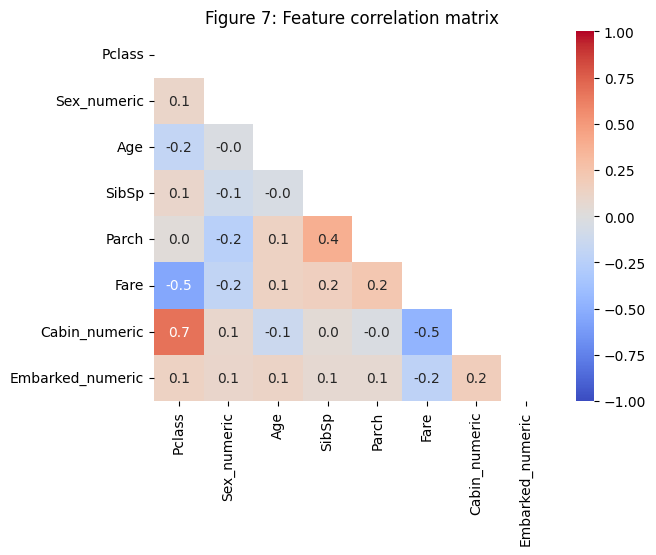

In [129]:
# collapse

matrix = np.triu(X_train[raw_features].corr())
plt.title(f"Figure 7: Feature correlation matrix")
sns.heatmap(X_train[raw_features].corr(), vmin=-1, vmax=1, annot=True, fmt='.1f', center=0, cmap='coolwarm', mask=matrix)

The performance of the Randomforest algorithm is highly dependent on hyperparameter tuning. Here, we will use Grid search method to find the best hyperparameter. 

In [114]:
# collapse

rf = RandomForestClassifier() 
parameters = {
    'n_estimators': [ 2 ** i for i in range(1,9)], 
    'max_depth': [2,4,8, 15,17,20, None]
}

cv = GridSearchCV(rf, cv=5, param_grid=parameters)
cv.fit(X_train[raw_features], y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 8, 15, 17, 20, None],
                         'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256]})

In [115]:
# collapse_output
def print_result(results):
    print(f"Best parameters: \n{results.best_params_}")
    
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f"{round(mean,3)} (+/-{round(std*2,3)}) for {params} ")
        
print_result(cv)

Best parameters: 
{'max_depth': 8, 'n_estimators': 64}
0.717 (+/-0.103) for {'max_depth': 2, 'n_estimators': 2} 
0.727 (+/-0.092) for {'max_depth': 2, 'n_estimators': 4} 
0.751 (+/-0.088) for {'max_depth': 2, 'n_estimators': 8} 
0.753 (+/-0.052) for {'max_depth': 2, 'n_estimators': 16} 
0.758 (+/-0.058) for {'max_depth': 2, 'n_estimators': 32} 
0.771 (+/-0.036) for {'max_depth': 2, 'n_estimators': 64} 
0.757 (+/-0.088) for {'max_depth': 2, 'n_estimators': 128} 
0.766 (+/-0.054) for {'max_depth': 2, 'n_estimators': 256} 
0.749 (+/-0.127) for {'max_depth': 4, 'n_estimators': 2} 
0.77 (+/-0.033) for {'max_depth': 4, 'n_estimators': 4} 
0.777 (+/-0.061) for {'max_depth': 4, 'n_estimators': 8} 
0.798 (+/-0.033) for {'max_depth': 4, 'n_estimators': 16} 
0.794 (+/-0.036) for {'max_depth': 4, 'n_estimators': 32} 
0.803 (+/-0.05) for {'max_depth': 4, 'n_estimators': 64} 
0.783 (+/-0.033) for {'max_depth': 4, 'n_estimators': 128} 
0.788 (+/-0.036) for {'max_depth': 4, 'n_estimators': 256} 
0.728

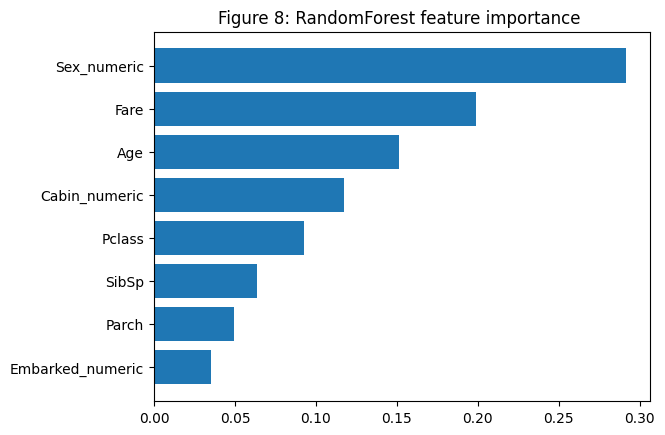

In [131]:
# collapse

feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [X_train[raw_features].columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], align='center')
plt.title(f"Figure 8: RandomForest feature importance ")
plt.show()

Figure 8 shows the feature importance for the best randomforest model. Model gives the higherst importance to feature `Sex` and the lowest importance to feature `Embarked` which is plausible. We have also observed this while exploring the data.

Surprisingly, it give higher importance to `Fare` than `Pclass`. Fare is dependent on Pclass and cabin and not other way around. Here, model is getting confused. 